# Importing Packages:

In [271]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [272]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pyarrow

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import pickle

# Reading Incident_Report Data:

In [273]:
repo_inci = pd.read_parquet('Incident_Report.parquet', engine='pyarrow')
repo_inci=repo_inci[repo_inci.FacilityId==9]
repo_inci.head()

,Id,FacilityId,IncidentType,IncidentTransportNumber,IncidentSensitive,PortalIRNumber,DateOccured,LocationDetails,IncidentLinkedParticipantDetainee,IncidentDamge,ActualIncidentResolved,IncidentLevel,ODS_Update_Datetime
25,5882,9,Accident / Injury - Minor,None,No,None,2016-10-13 17:20:23,IDC Blaxland,0,No,None,Minor,2016-10-18 16:06:01
241,76626,9,Visitor - other refused access,None,No,1-9E6VS1N,2016-12-14 14:40:16,None,1,No,2016-12-14 14:40:44,Minor,2018-11-01 22:01:35
357,72402,9,Contraband found,None,No,1-9DFNG9G,2016-12-12 15:38:00,IDC Blaxland,1,No,2016-12-12 15:38:39,Minor,2019-07-25 16:03:31
392,76463,9,Use of Force - Planned,1-20062350358,No,1-9E83G40,2016-12-14 12:45:39,Villawood IDC Offsite,1,No,2017-02-06 19:00:00,Minor,2017-02-07 04:05:39
394,73204,9,Failure - security systems,None,No,1-9DLCKZC,2016-12-13 03:10:00,Common Area,0,No,2016-12-13 03:10:00,Major,2017-05-11 16:08:12


In [274]:
repo_inci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41558 entries, 25 to 103493
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Id                                 41558 non-null  int32         
 1   FacilityId                         41558 non-null  int32         
 2   IncidentType                       41511 non-null  object        
 3   IncidentTransportNumber            2889 non-null   object        
 4   IncidentSensitive                  41510 non-null  object        
 5   PortalIRNumber                     41371 non-null  object        
 6   DateOccured                        41499 non-null  object        
 7   LocationDetails                    41197 non-null  object        
 8   IncidentLinkedParticipantDetainee  41558 non-null  object        
 9   IncidentDamge                      41553 non-null  object        
 10  ActualIncidentResolved          

# Extracting usable Date features from DateOccured column:

In [275]:
data = pd.to_datetime(repo_inci.DateOccured,errors = 'coerce').dt.normalize().to_frame()
data['year'] = data.DateOccured.dt.year
data['quarter'] = data.DateOccured.dt.quarter
data['month'] = data.DateOccured.dt.month
data['dayofmonth'] = data.DateOccured.dt.day
data['dayofweek'] = data.DateOccured.dt.day_of_week
data['weekofyear'] = data.DateOccured.dt.weekofyear
data['dayofyear'] = data.DateOccured.dt.day_of_year
data.head()

,DateOccured,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear
25,2016-10-13,2016.00,4.00,10.00,13.00,3.00,41.00,287.00
241,2016-12-14,2016.00,4.00,12.00,14.00,2.00,50.00,349.00
357,2016-12-12,2016.00,4.00,12.00,12.00,0.00,50.00,347.00
392,2016-12-14,2016.00,4.00,12.00,14.00,2.00,50.00,349.00
394,2016-12-13,2016.00,4.00,12.00,13.00,1.00,50.00,348.00


# Grouping by day to get the total number of incidents occured in each day:

In [276]:
data = data.groupby(by=data.columns.to_list()).size().reset_index()
data.head()

,DateOccured,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,0
0,1986-11-16,1986.00,4.00,11.00,16.00,6.00,46.00,320.00,1
1,2000-01-01,2000.00,1.00,1.00,1.00,5.00,52.00,1.00,1
2,2010-12-06,2010.00,4.00,12.00,6.00,0.00,49.00,340.00,1
3,2011-07-13,2011.00,3.00,7.00,13.00,2.00,28.00,194.00,1
4,2011-10-11,2011.00,4.00,10.00,11.00,1.00,41.00,284.00,1


In [277]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209 entries, 0 to 2208
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateOccured  2209 non-null   datetime64[ns]
 1   year         2209 non-null   float64       
 2   quarter      2209 non-null   float64       
 3   month        2209 non-null   float64       
 4   dayofmonth   2209 non-null   float64       
 5   dayofweek    2209 non-null   float64       
 6   weekofyear   2209 non-null   float64       
 7   dayofyear    2209 non-null   float64       
 8   0            2209 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 155.4 KB


In [278]:
data[0].value_counts().sort_values()

48      1
46      1
54      1
43      3
41      5
2       7
47      7
40      7
44      8
42      9
3      10
45     10
39     14
1      15
38     18
37     19
35     25
4      27
34     27
32     31
30     32
36     33
6      34
33     35
31     38
5      40
29     41
7      49
28     50
27     52
26     53
25     53
24     62
21     68
23     68
20     69
18     75
8      76
22     77
19     83
9      86
16     91
17     92
11     92
14     96
13     96
15     98
12    105
10    120
Name: 0, dtype: int64

# Plotting the total number of incidents occured in each day:

In [279]:
px.line(data, x="DateOccured", y=0, title='Incidents Through Time')

## From this chart we can find that there're some entry error in the dates, as there are dates after 2022, also the data before 2022 are so biased as before 2017 all the total numbers of incidents were hardly 1 incident per each date, that will lead to poor predictions, finally there're some outlied data that need to be droped.

In [280]:
data = data[data.year<=2022][data.year>=2017]
px.line(data, x="DateOccured", y=0, title='Incidents Through Time (Cleaned)')

## Let's plot ACF and PACF to see if there're any data lags that we may make use of:

In [281]:
import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

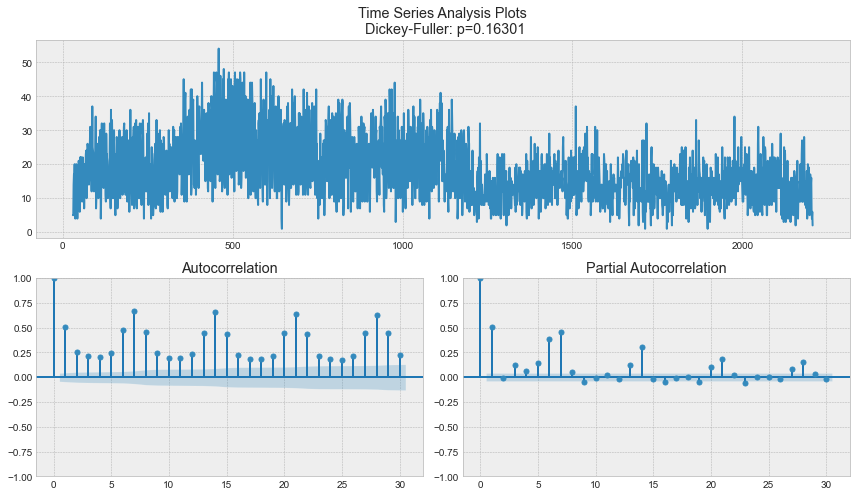

In [282]:
tsplot(data[0], lags=30)

### From the last two gaph we can find that lags 1,6,7,8 are the most effictive lags to our data, let's extract them to be features in our train data.

In [283]:
for i in [1,6,7,8]:
    data["lag_{}".format(i)] = data[0].shift(i)

In [284]:
data.head()

,DateOccured,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,0,lag_1,lag_6,lag_7,lag_8
30,2017-01-01,2017.00,1.00,1.00,1.00,6.00,52.00,1.00,5,NaN,NaN,NaN,NaN
31,2017-01-02,2017.00,1.00,1.00,2.00,0.00,1.00,2.00,5,5.00,NaN,NaN,NaN
32,2017-01-03,2017.00,1.00,1.00,3.00,1.00,1.00,3.00,14,5.00,NaN,NaN,NaN
33,2017-01-04,2017.00,1.00,1.00,4.00,2.00,1.00,4.00,17,14.00,NaN,NaN,NaN
34,2017-01-05,2017.00,1.00,1.00,5.00,3.00,1.00,5.00,15,17.00,NaN,NaN,NaN


## Now let's plot the dataset correlations to see how much the features are correlated to each other:

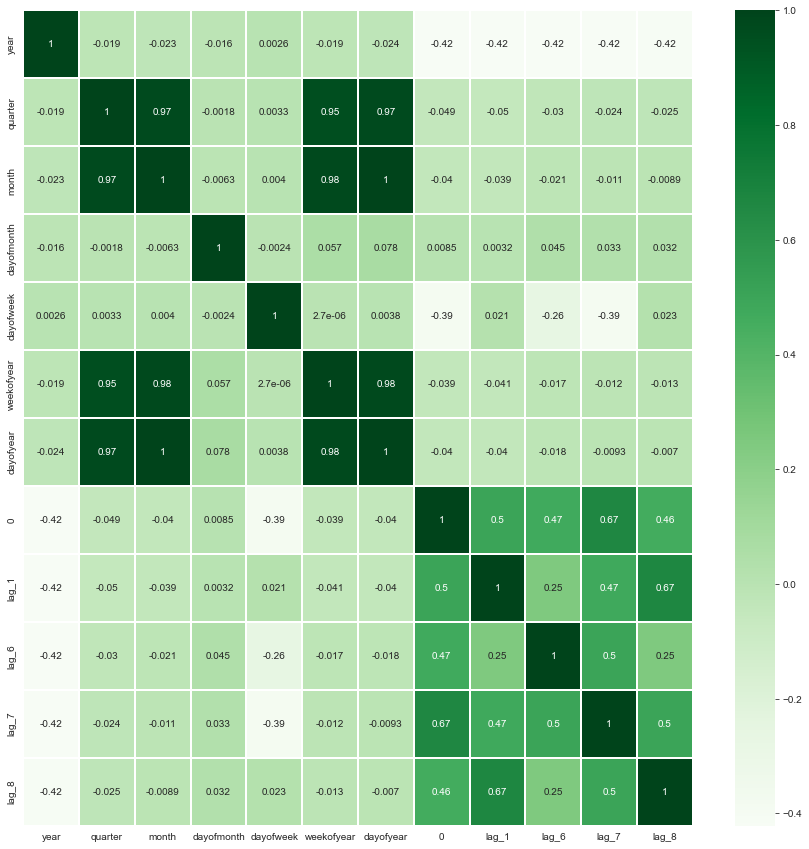

In [285]:
data.dropna(axis=0,inplace=True)
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":10});

### From the last graph we can notice that year, dayofweek and the lags are the most correlated features to our target.

## Now let's start preprocessing the data to be modeled:

In [286]:
X_train_full = data.dropna(axis=0).drop(['DateOccured',0], axis =1)
y_train_full = data[0]

# Scaling the data. 
data_scaler = StandardScaler()
# target_scaler = StandardScaler()


scaled_data = data_scaler.fit_transform(X_train_full.values)
# scaled_target = target_scaler.fit_transform(y_train_full.values.reshape(-1, 1))

scaled_data= pd.DataFrame(scaled_data, index=X_train_full.index, columns=X_train_full.columns)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full,test_size=0.1, shuffle=False)

## Using GridSearchCV to tune XGBRegressor parameters and get the best estimator of it

In [287]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBRegressor()

grid = GridSearchCV(xgb, params).fit(X_train,y_train)

In [288]:
xgb = grid.best_estimator_
xgb

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Lets validat our model on some basic metrics.

1- Mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon, or in other words it's measure of errors between the real values and the predictions. (The higher it goes the worst predictions are.)

2- Mean Squared Error (MSE) measures the average of the squares of the errors—that is, the average squared difference between the estimated values (predictions) and the actual value. (The higher it goes the worst predictions are.)

3- Root Mean Squared Error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. (The higher it goes the worst predictions are.)

4- R² (R-Squared) is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. (The higher it goes the better predictions are.)

In [289]:
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_valid)
# xgb_pred = target_scaler.inverse_transform(xgb_pred.reshape(-1, 1))

xgbmae = mean_absolute_error(y_valid, xgb_pred)
xgbmse = mean_squared_error(y_valid, xgb_pred)
xgbrmse = np.sqrt(xgbmse)
xgbr2 = r2_score(y_valid, xgb_pred)

print(f'''
(a) xgb Mean Absolute Error (MAE): {xgbmae}
(b) xgb Mean Squared Error (MSE): {xgbmse}
(c) xgb Root Mean Squared Error (RMSE): {xgbrmse}
(d) xgb R² (R-Squared): {xgbr2}
''')


(a) xgb Mean Absolute Error (MAE): 4.8049247715330345
(b) xgb Mean Squared Error (MSE): 33.883871827409585
(c) xgb Root Mean Squared Error (RMSE): 5.820985468750939
(d) xgb R² (R-Squared): 0.10693868157405406



## Visualizing the data and predictions:

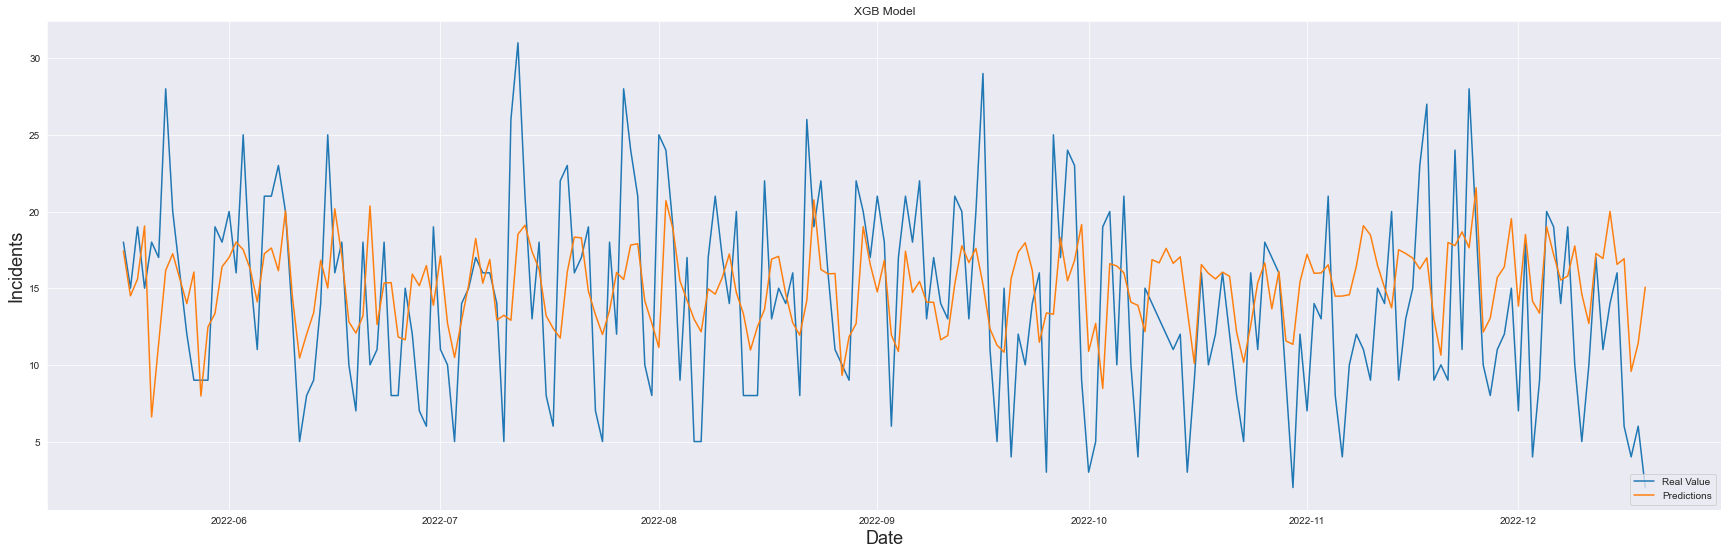

In [290]:
# Visualize the data
train = data[:len(X_train)]
valid = data[len(X_train):].set_index('DateOccured')
valid['Predictions'] = xgb_pred

plt.figure(figsize=(30,9))
plt.title('XGB Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Incidents', fontsize=18)
plt.plot(valid[[0, 'Predictions']])
plt.legend([ 'Real Value', 'Predictions'], loc='lower right')
plt.show()

In [291]:
len(X_valid)

217

### From the last graph we can find that our model gives really realistic predictions, as the predictions (the orange line) aren't that far from the the actual values (the blue line), but I believe that it can go better more.

## Feature engineering and importance:

In [292]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb, random_state=0).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.3830 ± 0.0921,dayofweek
0.0505 ± 0.0510,lag_1
0.0024 ± 0.0410,lag_6
0.0018 ± 0.0078,weekofyear
0 ± 0.0000,year
-0.0027 ± 0.0023,quarter
-0.0057 ± 0.0106,dayofmonth
-0.0079 ± 0.0196,dayofyear
-0.0081 ± 0.0050,month
-0.0289 ± 0.0316,lag_8


### From the last table that has a "Weight" column that represents how much important a feature is, and "Feature" column that has features names, and luckily it's sorted from the most important column at the top of it and vice versa

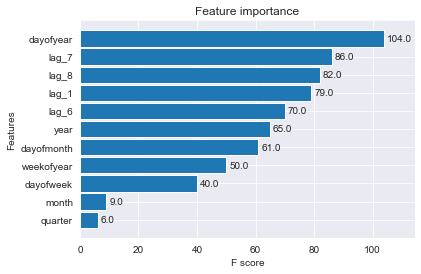

In [293]:
from xgboost import plot_importance, plot_tree

_ = plot_importance(xgb, height=0.9)

### Two different methods and two different results, so let's only use the tops of each of them:

In [294]:
xgb.fit(X_train[['dayofweek','lag_6','lag_7','lag_8','lag_1']],y_train)
xgb_pred = xgb.predict(X_valid[['dayofweek','lag_6','lag_7','lag_8','lag_1']])
# xgb_pred = target_scaler.inverse_transform(xgb_pred.reshape(-1, 1))

xgbmae = mean_absolute_error(y_valid, xgb_pred)
xgbmse = mean_squared_error(y_valid, xgb_pred)
xgbrmse = np.sqrt(xgbmse)
xgbr2 = r2_score(y_valid, xgb_pred)

print(f'''
(a) xgb Mean Absolute Error (MAE): {xgbmae}
(b) xgb Mean Squared Error (MSE): {xgbmse}
(c) xgb Root Mean Squared Error (RMSE): {xgbrmse}
(d) xgb R² (R-Squared): {xgbr2}
''')


(a) xgb Mean Absolute Error (MAE): 4.370404311588833
(b) xgb Mean Squared Error (MSE): 30.073691560384347
(c) xgb Root Mean Squared Error (RMSE): 5.483948537357398
(d) xgb R² (R-Squared): 0.2073618159207471



### Now we can notice that our predictions have become more accurate.

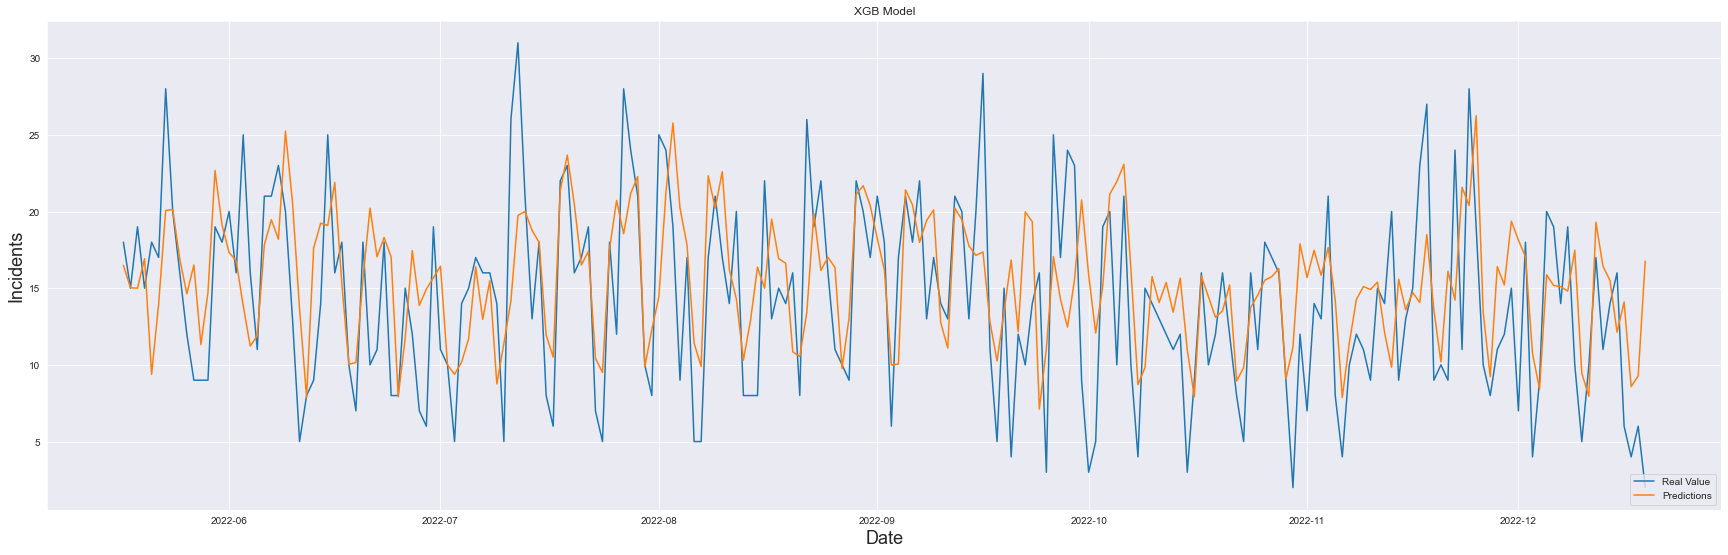

In [295]:
# Visualize the data
train = data[:len(X_train)]
valid = data[len(X_train):].set_index('DateOccured')
valid['Predictions'] = xgb_pred

plt.figure(figsize=(30,9))
plt.title('XGB Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Incidents', fontsize=18)
plt.plot(valid[[0, 'Predictions']])
plt.legend([ 'Real Value', 'Predictions'], loc='lower right')
plt.show()

## Now we can see how much accurate the predictions have become, as if you noticed, the distance (Error) between predictions and actual values has become less than it's in the graph before Feature engineering our data.

## Creating Excel file for the predictions:

In [296]:
valid.Predictions = round(valid.Predictions)
valid

,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,0,lag_1,lag_6,lag_7,lag_8,Predictions
DateOccured,,,,,,,,,,,,,
2022-05-17,2022.00,2.00,5.00,17.00,1.00,20.00,137.00,18,17.00,20.00,13.00,18.00,16.00
2022-05-18,2022.00,2.00,5.00,18.00,2.00,20.00,138.00,15,18.00,15.00,20.00,13.00,15.00
2022-05-19,2022.00,2.00,5.00,19.00,3.00,20.00,139.00,19,15.00,12.00,15.00,20.00,15.00
2022-05-20,2022.00,2.00,5.00,20.00,4.00,20.00,140.00,15,19.00,25.00,12.00,15.00,17.00
2022-05-21,2022.00,2.00,5.00,21.00,5.00,20.00,141.00,18,15.00,14.00,25.00,12.00,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-15,2022.00,4.00,12.00,15.00,3.00,50.00,349.00,16,14.00,10.00,19.00,14.00,12.00
2022-12-16,2022.00,4.00,12.00,16.00,4.00,50.00,350.00,6,16.00,5.00,10.00,19.00,14.00
2022-12-17,2022.00,4.00,12.00,17.00,5.00,50.00,351.00,4,6.00,10.00,5.00,10.00,9.00


In [297]:
ve = valid.reset_index()[['DateOccured',0,'Predictions']].rename(columns={0:'Aactual count of incidents','DateOccured':'Date','Predictions':'predicted number of incidents'}).iloc[:-1,:]
ve

,Date,Aactual count of incidents,predicted number of incidents
0,2022-05-17,18,16.00
1,2022-05-18,15,15.00
2,2022-05-19,19,15.00
3,2022-05-20,15,17.00
4,2022-05-21,18,9.00
...,...,...,...
211,2022-12-14,14,15.00
212,2022-12-15,16,12.00
213,2022-12-16,6,14.00
214,2022-12-17,4,9.00


In [299]:
ve.to_excel('XGBoost Predictions.xlsx',index=False)

# Incident Level:
## Let's read our three datasets:

In [ ]:
date_pro = pd.read_parquet('Detainee_Profile.parquet', engine='pyarrow')
date_pro.head()

,Id,DetaineeId,FacilityId,DetaineeTimeInDetention,cbxReligion,PreferredLanguage,DetaineeGender,DetentionDetails,DetaineeDOB,DetentionReason,...,MedicalCategory,EscortRisk,DietaryCategory,BehaviourDetails,BahaviourCategory,FoodFluidRefusalCommencementDate,FoodFluidRefusalClosureDate,EnhancedMonitoringCommencementDate,DetaineeServiceID,ODS_Update_Datetime
0,9325,590,4,298,Not Stated,Not Stated,Male,From community,1973-07-02 00:00:00,Compliance,...,No Information,High,No Information,History,None,None,None,None,1-76QB83G,2017-03-15 16:05:50.000
1,3284875,25943,9,None,Christian (NFD),Fijian,Male,501,1999-04-23 00:00:00,Compliance,...,No Information,High,Self Disclosed,Sexual offences,None,None,None,2022-06-04 15:22:44,1-HUD03RQ,2022-08-11 05:03:55.143
2,3152322,21657,11,None,Not Stated,English,Male,501,1983-12-02 00:00:00,Compliance,...,None,High,None,None,None,None,None,2022-03-22 16:42:00,TEMP315232001,2022-05-16 05:04:05.203
3,9336,592,5,1178,Islam,Somali,Male,None,1994-12-31 00:00:00,IMA,...,Current,High,Self Disclosed,History,None,None,None,None,1-113NV5O,2017-06-08 15:05:51.000
4,3273679,25921,1,None,Not Stated,Vietnamese,Male,501,1967-01-19 00:00:00,Compliance,...,None,Medium,None,None,None,None,None,None,1-IOZIMZ7,2022-08-18 05:04:05.767


In [ ]:
date_pro = date_pro[['DetaineeServiceID','ODS_Update_Datetime','cbxReligion', 'PreferredLanguage' , 'DetaineeGender'  , 'DetentionReason' , 'DetaineeCitizenship' , 'DetaineeMaritalStatus' , 'DetaineeFamilyStatus' , 'SelfHarmDetails' , 'SelfHarmCategory' , 'SelfAdminMedCategory' , 'SelfAdminMedDetails' , 'PlacementRisk' , 'MedicalDetails' , 'MedicalCategory' , 'EscortRisk' ,'BehaviourDetails' ,'DetaineeDOB']]
date_pro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27622 entries, 0 to 27621
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DetaineeServiceID      27552 non-null  object        
 1   ODS_Update_Datetime    27622 non-null  datetime64[ns]
 2   cbxReligion            27467 non-null  object        
 3   PreferredLanguage      27468 non-null  object        
 4   DetaineeGender         27469 non-null  object        
 5   DetentionReason        27466 non-null  object        
 6   DetaineeCitizenship    27469 non-null  object        
 7   DetaineeMaritalStatus  18644 non-null  object        
 8   DetaineeFamilyStatus   20398 non-null  object        
 9   SelfHarmDetails        1450 non-null   object        
 10  SelfHarmCategory       10080 non-null  object        
 11  SelfAdminMedCategory   9171 non-null   object        
 12  SelfAdminMedDetails    246 non-null    object        
 13  P

In [ ]:
date_inci = pd.read_parquet('Incident_Detainees.parquet', engine='pyarrow')
date_inci.head()

,Id,Seq,IncidentDetaineeParticipationType,IncidentDetaineeParticipantArmed,DetaineeServiceID,ODS_Update_Datetime
0,4952,101,Involved,Yes,1-84NCMFB,2016-10-27 16:06:03
1,4019,101,Involved,No,1-8PPTC3R,2016-10-18 16:06:01
2,6476,101,Involved,No,1-125VTI6,2016-10-31 04:05:42
3,3145,101,Involved,No,1-8HPEZMQ,2016-10-18 16:06:01
4,8136,101,Involved,No,1-8SJ5H7O,2016-10-18 16:06:01


In [ ]:
date_inci = date_inci[['Id','IncidentDetaineeParticipationType','DetaineeServiceID']]
date_inci.head()

,Id,IncidentDetaineeParticipationType,DetaineeServiceID
0,4952,Involved,1-84NCMFB
1,4019,Involved,1-8PPTC3R
2,6476,Involved,1-125VTI6
3,3145,Involved,1-8HPEZMQ
4,8136,Involved,1-8SJ5H7O


In [ ]:
repo_inci = pd.read_parquet('Incident_Report.parquet', engine='pyarrow')
repo_inci=repo_inci[repo_inci.FacilityId==9]
repo_inci.head()

,Id,FacilityId,IncidentType,IncidentTransportNumber,IncidentSensitive,PortalIRNumber,DateOccured,LocationDetails,IncidentLinkedParticipantDetainee,IncidentDamge,ActualIncidentResolved,IncidentLevel,ODS_Update_Datetime
25,5882,9,Accident / Injury - Minor,None,No,None,2016-10-13 17:20:23,IDC Blaxland,0,No,None,Minor,2016-10-18 16:06:01
241,76626,9,Visitor - other refused access,None,No,1-9E6VS1N,2016-12-14 14:40:16,None,1,No,2016-12-14 14:40:44,Minor,2018-11-01 22:01:35
357,72402,9,Contraband found,None,No,1-9DFNG9G,2016-12-12 15:38:00,IDC Blaxland,1,No,2016-12-12 15:38:39,Minor,2019-07-25 16:03:31
392,76463,9,Use of Force - Planned,1-20062350358,No,1-9E83G40,2016-12-14 12:45:39,Villawood IDC Offsite,1,No,2017-02-06 19:00:00,Minor,2017-02-07 04:05:39
394,73204,9,Failure - security systems,None,No,1-9DLCKZC,2016-12-13 03:10:00,Common Area,0,No,2016-12-13 03:10:00,Major,2017-05-11 16:08:12


In [ ]:
repo_inci = repo_inci[['Id','IncidentType','DateOccured','IncidentLevel']]
repo_inci.head()

,Id,IncidentType,DateOccured,IncidentLevel
25,5882,Accident / Injury - Minor,2016-10-13 17:20:23,Minor
241,76626,Visitor - other refused access,2016-12-14 14:40:16,Minor
357,72402,Contraband found,2016-12-12 15:38:00,Minor
392,76463,Use of Force - Planned,2016-12-14 12:45:39,Minor
394,73204,Failure - security systems,2016-12-13 03:10:00,Major


## Cleaning:
### The first step in cleaning our data will be to merge (join) them together to get a single dataset that holds all of our data in one place:

In [ ]:
data = date_pro.merge(date_inci,on='DetaineeServiceID').merge(repo_inci,on='Id')
data.head()

,DetaineeServiceID,ODS_Update_Datetime,cbxReligion,PreferredLanguage,DetaineeGender,DetentionReason,DetaineeCitizenship,DetaineeMaritalStatus,DetaineeFamilyStatus,SelfHarmDetails,...,MedicalDetails,MedicalCategory,EscortRisk,BehaviourDetails,DetaineeDOB,Id,IncidentDetaineeParticipationType,IncidentType,DateOccured,IncidentLevel
0,1-HUD03RQ,2022-08-11 05:03:55.143,Christian (NFD),Fijian,Male,Compliance,FIJI,Single,Single Adult Male,None,...,None,No Information,High,Sexual offences,1999-04-23 00:00:00,3364132,Involved,Use of Force - Planned,2022-08-10 02:40:00,Minor
1,1-HUD03RQ,2022-08-11 05:03:55.143,Christian (NFD),Fijian,Male,Compliance,FIJI,Single,Single Adult Male,None,...,None,No Information,High,Sexual offences,1999-04-23 00:00:00,3286743,Involved,Use of Force,2022-06-06 10:55:00,Major
2,1-HUD03RQ,2022-08-11 05:03:55.143,Christian (NFD),Fijian,Male,Compliance,FIJI,Single,Single Adult Male,None,...,None,No Information,High,Sexual offences,1999-04-23 00:00:00,3290589,Involved,Use of Force,2022-06-09 17:15:00,Major
3,1-HUD03RQ,2022-08-11 05:03:55.143,Christian (NFD),Fijian,Male,Compliance,FIJI,Single,Single Adult Male,None,...,None,No Information,High,Sexual offences,1999-04-23 00:00:00,3284856,Involved,Use of Force - Planned,2022-06-04 11:40:00,Minor
4,1-BXTIKIO,2018-02-28 10:01:20.000,Not Stated,Mandarin,Male,Compliance,"CHINA, PEOPLES REPUBLIC OF",Single,Single Adult Male,None,...,None,No Information,High,None,1983-11-30 00:00:00,665254,Involved,Visitor - other refused access,2017-10-11 19:22:18,Minor


### Now let's drop some unnecessary columns and proceed:

In [ ]:
data.drop(['DetaineeServiceID','ODS_Update_Datetime','Id'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46332 entries, 0 to 46331
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   cbxReligion                        44919 non-null  object
 1   PreferredLanguage                  44919 non-null  object
 2   DetaineeGender                     44919 non-null  object
 3   DetentionReason                    44918 non-null  object
 4   DetaineeCitizenship                44919 non-null  object
 5   DetaineeMaritalStatus              37680 non-null  object
 6   DetaineeFamilyStatus               40095 non-null  object
 7   SelfHarmDetails                    7492 non-null   object
 8   SelfHarmCategory                   34146 non-null  object
 9   SelfAdminMedCategory               30166 non-null  object
 10  SelfAdminMedDetails                507 non-null    object
 11  PlacementRisk                      44149 non-null  object
 12  Medi

### Here I'll drop any Null values in our primary columns that are 'DateOccured','IncidentLevel':

In [ ]:
data.dropna(subset=['DateOccured','IncidentLevel'],inplace=True)

### Now I'll extarct some usable date data from DateOccured column:

In [ ]:
data['DateOccured'] = pd.to_datetime(repo_inci.DateOccured,errors = 'coerce').dt.normalize()
data['DetaineeDOB'] = pd.to_datetime(repo_inci.DateOccured,errors = 'coerce')
data['year'] = data.DateOccured.dt.year
data['quarter'] = data.DateOccured.dt.quarter
data['month'] = data.DateOccured.dt.month
data['dayofmonth'] = data.DateOccured.dt.day
data['dayofweek'] = data.DateOccured.dt.day_of_week
data['weekofyear'] = data.DateOccured.dt.weekofyear
data['dayofyear'] = data.DateOccured.dt.day_of_year
data = data[data.year<=2022]
data['age'] = 2022 -  data['DetaineeDOB'].dt.year
data.drop(['DetaineeDOB'],axis=1,inplace=True)
data.head()

,cbxReligion,PreferredLanguage,DetaineeGender,DetentionReason,DetaineeCitizenship,DetaineeMaritalStatus,DetaineeFamilyStatus,SelfHarmDetails,SelfHarmCategory,SelfAdminMedCategory,...,DateOccured,IncidentLevel,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,age
25,Not Stated,English,Male,Compliance,NEW ZEALAND,None,None,None,None,None,...,2016-10-13,Minor,2016.00,4.00,10.00,13.00,3.00,41.00,287.00,6
241,Christian (NFD),English,Male,Compliance,NEW ZEALAND,Married,Single Adult Male,Nil,Current,No,...,2016-12-14,Minor,2016.00,4.00,12.00,14.00,2.00,50.00,349.00,6
357,Catholic (NEC),English,Male,Compliance,FIJI,Married,Single Adult Male,None,No Information,No,...,2016-12-12,Minor,2016.00,4.00,12.00,12.00,0.00,50.00,347.00,6
392,Buddhism,English,Male,Compliance,MALAYSIA,Single,Single Adult Male,None,No Information,No,...,2016-12-14,Minor,2016.00,4.00,12.00,14.00,2.00,50.00,349.00,6
394,Not Stated,Not Stated,MALE,Compliance,NEW ZEALAND,None,Single Adult Male,None,No Information,None,...,2016-12-13,Minor,2016.00,4.00,12.00,13.00,1.00,50.00,348.00,6


### Filling all the Null values with 'Unknown':

In [ ]:
data.fillna('Unknown',inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20959 entries, 25 to 46331
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   cbxReligion                        20959 non-null  object        
 1   PreferredLanguage                  20959 non-null  object        
 2   DetaineeGender                     20959 non-null  object        
 3   DetentionReason                    20959 non-null  object        
 4   DetaineeCitizenship                20959 non-null  object        
 5   DetaineeMaritalStatus              20959 non-null  object        
 6   DetaineeFamilyStatus               20959 non-null  object        
 7   SelfHarmDetails                    20959 non-null  object        
 8   SelfHarmCategory                   20959 non-null  object        
 9   SelfAdminMedCategory               20959 non-null  object        
 10  SelfAdminMedDetails              

### Now let's get a list of each different data types columns in our data for upcoming filtering purposes:

In [ ]:
cat_columns = [column for column in data.columns if data[column].dtype == 'object']
cat_columns

['cbxReligion',
 'PreferredLanguage',
 'DetaineeGender',
 'DetentionReason',
 'DetaineeCitizenship',
 'DetaineeMaritalStatus',
 'DetaineeFamilyStatus',
 'SelfHarmDetails',
 'SelfHarmCategory',
 'SelfAdminMedCategory',
 'SelfAdminMedDetails',
 'PlacementRisk',
 'MedicalDetails',
 'MedicalCategory',
 'EscortRisk',
 'BehaviourDetails',
 'IncidentDetaineeParticipationType',
 'IncidentType',
 'IncidentLevel']

### Geting red of any white space and lowering the values of our categorical columns to avoid any data entry errors:

In [ ]:
for col in cat_columns:
    data[col] = data[col].str.lower().str.strip()

### Now let's see the count of unique values in our categorical columns:

In [ ]:
data[cat_columns].nunique()

cbxReligion                           48
PreferredLanguage                     67
DetaineeGender                         4
DetentionReason                        7
DetaineeCitizenship                  153
DetaineeMaritalStatus                 11
DetaineeFamilyStatus                   5
SelfHarmDetails                      145
SelfHarmCategory                       4
SelfAdminMedCategory                   3
SelfAdminMedDetails                   37
PlacementRisk                          5
MedicalDetails                       465
MedicalCategory                        4
EscortRisk                             5
BehaviourDetails                     209
IncidentDetaineeParticipationType      5
IncidentType                          53
IncidentLevel                          3
dtype: int64

### As you can see, there're some columns with a very high count of unique values that must be dropped to not make it harder for our model to make accurate predictions:

In [ ]:
data.drop(['cbxReligion','PreferredLanguage','DetaineeCitizenship','SelfHarmDetails','SelfAdminMedDetails','SelfAdminMedDetails','MedicalDetails','BehaviourDetails','IncidentType'] ,axis=1, inplace=True)
data.nunique()

DetaineeGender                         4
DetentionReason                        7
DetaineeMaritalStatus                 11
DetaineeFamilyStatus                   5
SelfHarmCategory                       4
SelfAdminMedCategory                   3
PlacementRisk                          5
MedicalCategory                        4
EscortRisk                             5
IncidentDetaineeParticipationType      5
DateOccured                          953
IncidentLevel                          3
year                                   7
quarter                                4
month                                 12
dayofmonth                            31
dayofweek                              7
weekofyear                            52
dayofyear                            366
age                                    7
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20959 entries, 25 to 46331
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   DetaineeGender                     20959 non-null  object        
 1   DetentionReason                    20959 non-null  object        
 2   DetaineeMaritalStatus              20959 non-null  object        
 3   DetaineeFamilyStatus               20959 non-null  object        
 4   SelfHarmCategory                   20959 non-null  object        
 5   SelfAdminMedCategory               20959 non-null  object        
 6   PlacementRisk                      20959 non-null  object        
 7   MedicalCategory                    20959 non-null  object        
 8   EscortRisk                         20959 non-null  object        
 9   IncidentDetaineeParticipationType  20959 non-null  object        
 10  DateOccured                      

## Grouping:
### Here I'll be grouping our big data set by day in three different ways:

In [ ]:
# Geting the names of the numrical columns.
cat_columns = [column for column in data.columns if data[column].dtype == 'object']
cat_columns

['DetaineeGender',
 'DetentionReason',
 'DetaineeMaritalStatus',
 'DetaineeFamilyStatus',
 'SelfHarmCategory',
 'SelfAdminMedCategory',
 'PlacementRisk',
 'MedicalCategory',
 'EscortRisk',
 'IncidentDetaineeParticipationType',
 'IncidentLevel']

In [ ]:
# Geting the names of the numrical columns.
num_columns = [column for column in data.columns if data[column].dtype != 'object']
num_columns

['DateOccured',
 'year',
 'quarter',
 'month',
 'dayofmonth',
 'dayofweek',
 'weekofyear',
 'dayofyear',
 'age']

In [ ]:
data.head()

,DetaineeGender,DetentionReason,DetaineeMaritalStatus,DetaineeFamilyStatus,SelfHarmCategory,SelfAdminMedCategory,PlacementRisk,MedicalCategory,EscortRisk,IncidentDetaineeParticipationType,DateOccured,IncidentLevel,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,age
25,male,compliance,unknown,unknown,unknown,unknown,high,unknown,high,involved,2016-10-13,minor,2016.00,4.00,10.00,13.00,3.00,41.00,287.00,6
241,male,compliance,married,single adult male,current,no,high,current,high,involved,2016-12-14,minor,2016.00,4.00,12.00,14.00,2.00,50.00,349.00,6
357,male,compliance,married,single adult male,no information,no,high,no information,high,involved,2016-12-12,minor,2016.00,4.00,12.00,12.00,0.00,50.00,347.00,6
392,male,compliance,single,single adult male,no information,no,low,no information,high,alleged offender,2016-12-14,minor,2016.00,4.00,12.00,14.00,2.00,50.00,349.00,6
394,male,compliance,unknown,single adult male,no information,unknown,high,no information,high,involved,2016-12-13,minor,2016.00,4.00,12.00,13.00,1.00,50.00,348.00,6


#### 1- Grouping by day to get the size or the count of each day repetion that is also represent the count of incidents in each day:

In [ ]:
grouped_size = data.groupby('DateOccured').size().reset_index().rename(columns={0:'Incidents_count'})
grouped_size

,DateOccured,Incidents_count
0,2010-12-06,1
1,2011-07-13,1
2,2011-10-11,1
3,2011-10-31,1
4,2016-10-13,1
...,...,...
948,2019-07-21,1
949,2019-07-22,2
950,2019-07-23,2
951,2019-07-24,2


#### 2- Grouping by day to get the count or frequency of each categorical value in each day:

In [ ]:
grouped_sum = pd.get_dummies(data.set_index('DateOccured')[cat_columns]).reset_index().groupby('DateOccured').sum().reset_index()
grouped_sum

,DateOccured,DetaineeGender_female,DetaineeGender_male,DetaineeGender_not stated,DetaineeGender_unknown,DetentionReason_born in detention,DetentionReason_compliance,DetentionReason_guest,DetentionReason_illegal foreign fisher,DetentionReason_ima,...,EscortRisk_medium,EscortRisk_unknown,IncidentDetaineeParticipationType_alleged offender,IncidentDetaineeParticipationType_involved,IncidentDetaineeParticipationType_unknown,IncidentDetaineeParticipationType_victim,IncidentDetaineeParticipationType_witness,IncidentLevel_critical,IncidentLevel_major,IncidentLevel_minor
0,2010-12-06,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2011-07-13,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2011-10-11,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,2011-10-31,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,2016-10-13,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,2019-07-21,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
949,2019-07-22,0,2,0,0,0,2,0,0,0,...,0,0,1,1,0,0,0,0,1,1
950,2019-07-23,1,1,0,0,0,2,0,0,0,...,0,0,0,2,0,0,0,0,1,1
951,2019-07-24,0,2,0,0,0,2,0,0,0,...,0,0,2,0,0,0,0,0,1,1


#### 3- finally grouping by day to get the numrical date data for each day:

In [ ]:
grouped_avg = data[num_columns].groupby('DateOccured').mean().reset_index()
grouped_avg

,DateOccured,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,age
0,2010-12-06,2010.00,4.00,12.00,6.00,0.00,49.00,340.00,12.00
1,2011-07-13,2011.00,3.00,7.00,13.00,2.00,28.00,194.00,11.00
2,2011-10-11,2011.00,4.00,10.00,11.00,1.00,41.00,284.00,11.00
3,2011-10-31,2011.00,4.00,10.00,31.00,0.00,44.00,304.00,11.00
4,2016-10-13,2016.00,4.00,10.00,13.00,3.00,41.00,287.00,6.00
...,...,...,...,...,...,...,...,...,...
948,2019-07-21,2019.00,3.00,7.00,21.00,6.00,29.00,202.00,3.00
949,2019-07-22,2019.00,3.00,7.00,22.00,0.00,30.00,203.00,3.00
950,2019-07-23,2019.00,3.00,7.00,23.00,1.00,30.00,204.00,3.00
951,2019-07-24,2019.00,3.00,7.00,24.00,2.00,30.00,205.00,3.00


### Now it's time to merge our 3 grouped data frames in one big grouped dataframe:

In [ ]:
grouped_data = grouped_size.merge(grouped_sum,on='DateOccured').merge(grouped_avg,on='DateOccured').set_index('DateOccured')
grouped_data.head()

,Incidents_count,DetaineeGender_female,DetaineeGender_male,DetaineeGender_not stated,DetaineeGender_unknown,DetentionReason_born in detention,DetentionReason_compliance,DetentionReason_guest,DetentionReason_illegal foreign fisher,DetentionReason_ima,...,IncidentLevel_major,IncidentLevel_minor,year,quarter,month,dayofmonth,dayofweek,weekofyear,dayofyear,age
DateOccured,,,,,,,,,,,,,,,,,,,,,
2010-12-06,1,0,1,0,0,0,1,0,0,0,...,0,1,2010.00,4.00,12.00,6.00,0.00,49.00,340.00,12.00
2011-07-13,1,0,1,0,0,0,1,0,0,0,...,0,1,2011.00,3.00,7.00,13.00,2.00,28.00,194.00,11.00
2011-10-11,1,0,1,0,0,0,1,0,0,0,...,0,1,2011.00,4.00,10.00,11.00,1.00,41.00,284.00,11.00
2011-10-31,1,1,0,0,0,0,1,0,0,0,...,1,0,2011.00,4.00,10.00,31.00,0.00,44.00,304.00,11.00
2016-10-13,1,0,1,0,0,0,1,0,0,0,...,0,1,2016.00,4.00,10.00,13.00,3.00,41.00,287.00,6.00


In [ ]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 953 entries, 2010-12-06 to 2020-02-04
Data columns (total 65 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Incidents_count                                     953 non-null    int64  
 1   DetaineeGender_female                               953 non-null    uint8  
 2   DetaineeGender_male                                 953 non-null    uint8  
 3   DetaineeGender_not stated                           953 non-null    uint8  
 4   DetaineeGender_unknown                              953 non-null    uint8  
 5   DetentionReason_born in detention                   953 non-null    uint8  
 6   DetentionReason_compliance                          953 non-null    uint8  
 7   DetentionReason_guest                               953 non-null    uint8  
 8   DetentionReason_illegal foreign fisher              953 non-n

### Let's plot a Heatmap of the grouped dataframe correlations to see how its columns are correlated with each other:

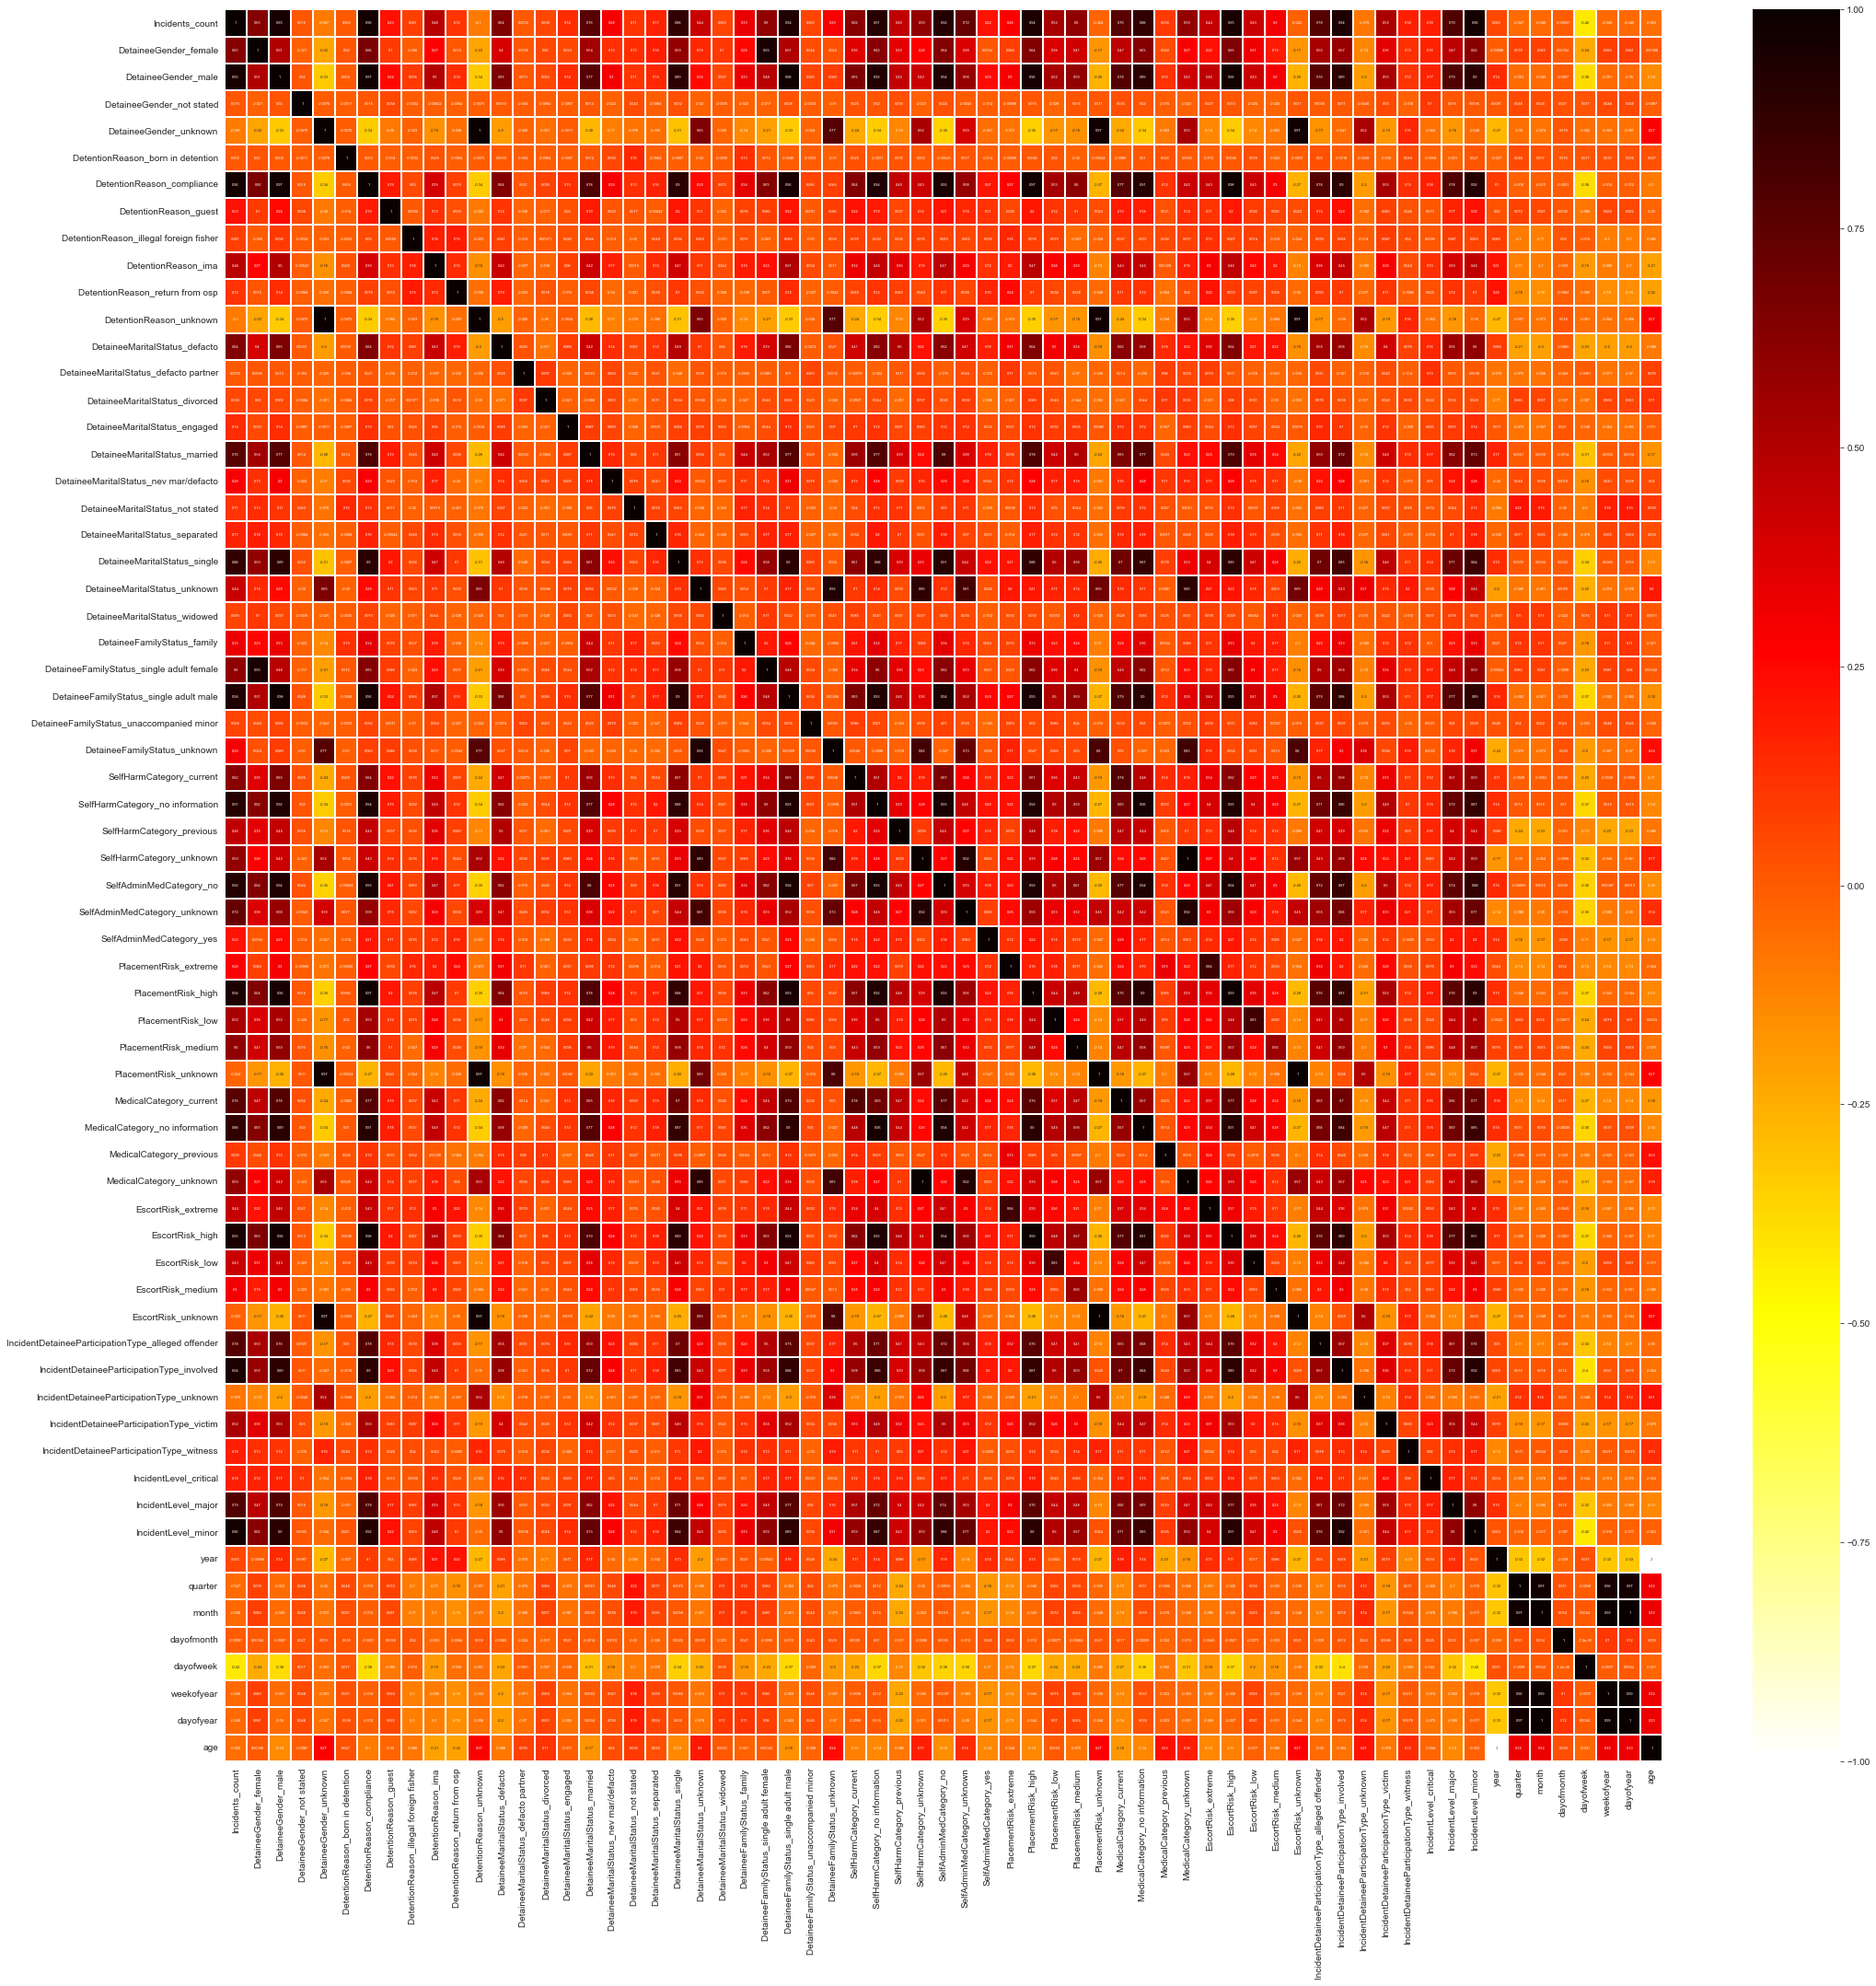

In [ ]:
plt.figure(figsize=(35, 35))
sns.heatmap(grouped_data.corr(), annot=True, cmap="hot_r", linewidths=0.1, annot_kws={"fontsize":4});

### From its dark look, I can tell that this data is correlated enough to lead to some good predictions.

## Preprocessing:

In [ ]:
# Creating train and test sets:
X = grouped_data.drop(['IncidentLevel_critical','IncidentLevel_major','IncidentLevel_minor'], axis =1)
y = grouped_data[['IncidentLevel_critical','IncidentLevel_major','IncidentLevel_minor']]

# Scaling the data. 
data_scaler = StandardScaler()
target_scaler = StandardScaler()


scaled_data = data_scaler.fit_transform(X.values)
scaled_target = target_scaler.fit_transform(y.values)

scaled_data= pd.DataFrame(scaled_data, index=X.index, columns=X.columns)
scaled_target= pd.DataFrame(scaled_target, index=y.index, columns=y.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_data,scaled_target,test_size=0.1,shuffle=False)

## Feature enigneering:

In [ ]:
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
xgb_pred = xgb.predict(x_test)

xgbmae = mean_absolute_error(y_test, xgb_pred)
xgbmse = mean_squared_error(y_test, xgb_pred)
xgbrmse = np.sqrt(xgbmse)
xgbr2 = r2_score(y_test, xgb_pred)

print(f'''
(a) xgb Mean Absolute Error (MAE): {xgbmae}
(b) xgb Mean Squared Error (MSE): {xgbmse}
(c) xgb Root Mean Squared Error (RMSE): {xgbrmse}
(d) xgb R² (R-Squared): {xgbr2}
''')


(a) xgb Mean Absolute Error (MAE): 0.27508763427854
(b) xgb Mean Squared Error (MSE): 0.33569894459028693
(c) xgb Root Mean Squared Error (RMSE): 0.5793953266900648
(d) xgb R² (R-Squared): 0.4504401977035579



In [ ]:
perm = PermutationImportance(xgb, random_state=0).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist(),top=65)

Weight,Feature
0.4794 ± 0.0779,Incidents_count
0.0556 ± 0.0201,MedicalCategory_no information
0.0314 ± 0.0377,DetaineeMaritalStatus_married
0.0295 ± 0.0509,IncidentDetaineeParticipationType_victim
0.0201 ± 0.0136,DetaineeFamilyStatus_single adult male
0.0170 ± 0.0140,PlacementRisk_high
0.0152 ± 0.0139,SelfAdminMedCategory_unknown
0.0127 ± 0.0138,DetaineeMaritalStatus_unknown
0.0127 ± 0.0085,DetaineeGender_male
0.0123 ± 0.0261,SelfAdminMedCategory_yes


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

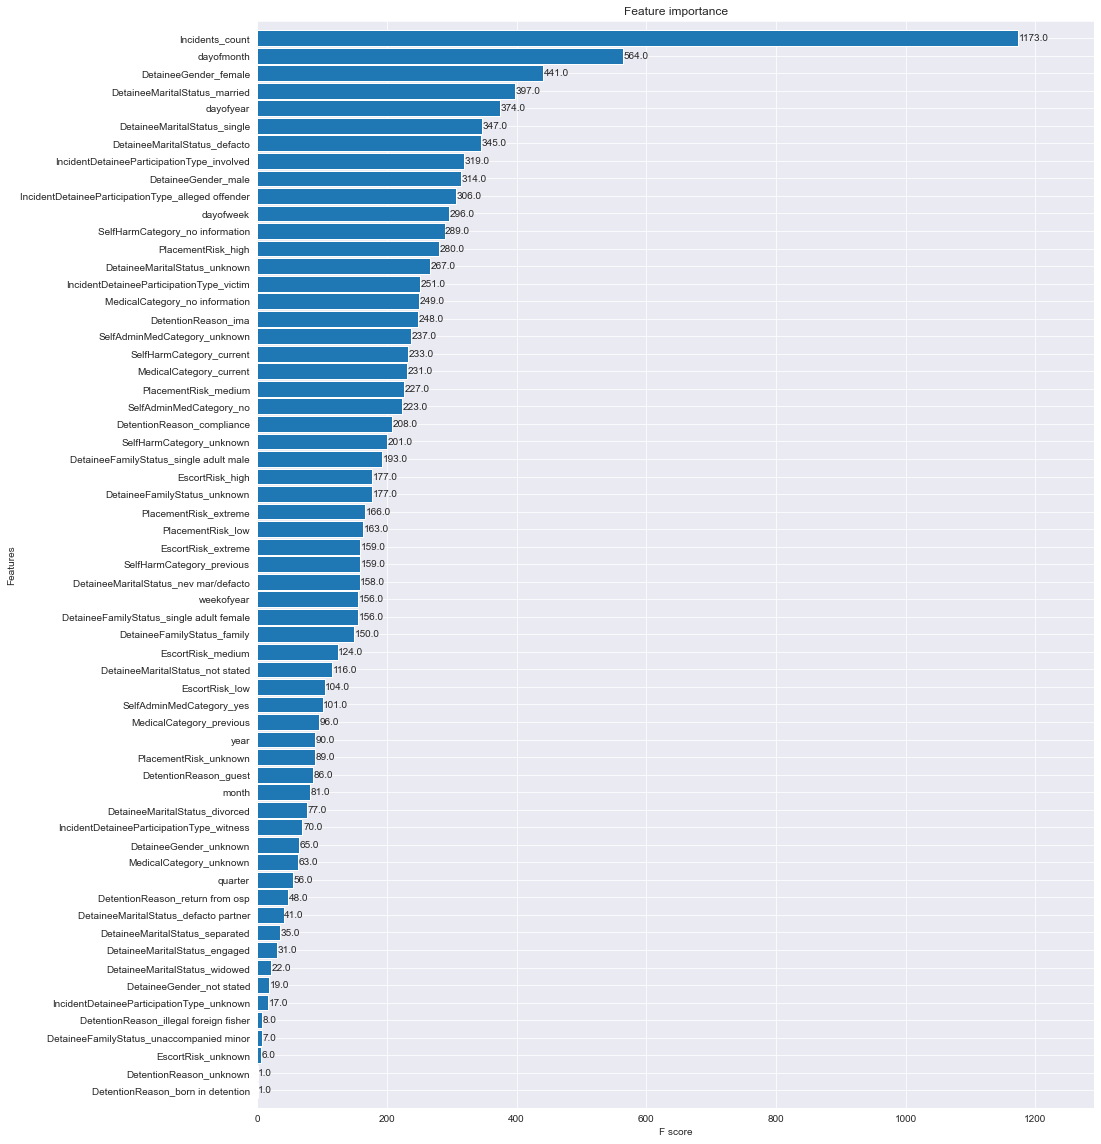

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))
plot_importance(xgb, height=0.9, ax=ax)

In [ ]:
cols = ['Incidents_count','DetentionReason_compliance','dayofyear','DetaineeGender_female','IncidentDetaineeParticipationType_involved','DetaineeMaritalStatus_married']
xgb = XGBRegressor()
xgb.fit(x_train[cols],y_train)
xgb_pred = xgb.predict(x_test[cols])

xgbmae = mean_absolute_error(y_test, xgb_pred)
xgbmse = mean_squared_error(y_test, xgb_pred)
xgbrmse = np.sqrt(xgbmse)
xgbr2 = r2_score(y_test, xgb_pred)

print(f'''
(a) xgb Mean Absolute Error (MAE): {xgbmae}
(b) xgb Mean Squared Error (MSE): {xgbmse}
(c) xgb Root Mean Squared Error (RMSE): {xgbrmse}
(d) xgb R² (R-Squared): {xgbr2}
''')


(a) xgb Mean Absolute Error (MAE): 0.2921787428615798
(b) xgb Mean Squared Error (MSE): 0.32634340858883254
(c) xgb Root Mean Squared Error (RMSE): 0.5712647447452298
(d) xgb R² (R-Squared): 0.4615588781555331



### From the change of these matrics before and after feature engineering, I can tell that we're heading forward.

## Hyperparameter Tuning

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBRegressor()

grid = GridSearchCV(xgb, params).fit(x_train[cols],y_train)

In [ ]:
xgb = grid.best_estimator_
xgb

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
xgb.fit(x_train[cols],y_train)
xgb_pred = xgb.predict(x_test[cols])

xgbmae = mean_absolute_error(y_test, xgb_pred)
xgbmse = mean_squared_error(y_test, xgb_pred)
xgbrmse = np.sqrt(xgbmse)
xgbr2 = r2_score(y_test, xgb_pred)

print(f'''
(a) xgb Mean Absolute Error (MAE): {xgbmae}
(b) xgb Mean Squared Error (MSE): {xgbmse}
(c) xgb Root Mean Squared Error (RMSE): {xgbrmse}
(d) xgb R² (R-Squared): {xgbr2}
''')


(a) xgb Mean Absolute Error (MAE): 0.29894184304013044
(b) xgb Mean Squared Error (MSE): 0.31850489091521783
(c) xgb Root Mean Squared Error (RMSE): 0.5643623755311987
(d) xgb R² (R-Squared): 0.45704077766249057



### Finally let's export our predictions:

In [ ]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2019-04-14 to 2020-02-04
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IncidentLevel_critical  96 non-null     float64
 1   IncidentLevel_major     96 non-null     float64
 2   IncidentLevel_minor     96 non-null     float64
dtypes: float64(3)
memory usage: 3.0 KB


In [ ]:
xgb_pred = pd.DataFrame(xgb_pred, index=y_test.index, columns=y_test.columns).astype('float64')

In [ ]:
res = pd.DataFrame(target_scaler.inverse_transform(y_test),index=y_test.index, columns=y_test.columns)
res[['Predicted IncidentLevel_critical','Predicted IncidentLevel_major','Predicted IncidentLevel_minor']] = np.abs(np.floor(target_scaler.inverse_transform(xgb_pred)))
res = res.reset_index().rename(columns={'DateOccured':'Date'}).merge(ve,on='Date')
res['predicted number of incidents'] = np.round(res['predicted number of incidents'])
res.iloc[:,1:] = res.iloc[:,1:].astype(int)
res = res.iloc[:-2,:]
res.head()

,Date,IncidentLevel_critical,IncidentLevel_major,IncidentLevel_minor,Predicted IncidentLevel_critical,Predicted IncidentLevel_major,Predicted IncidentLevel_minor,Aactual count of incidents,predicted number of incidents


In [ ]:
res.to_excel('XGBoost Incident Level Predictions.xlsx',index=False)

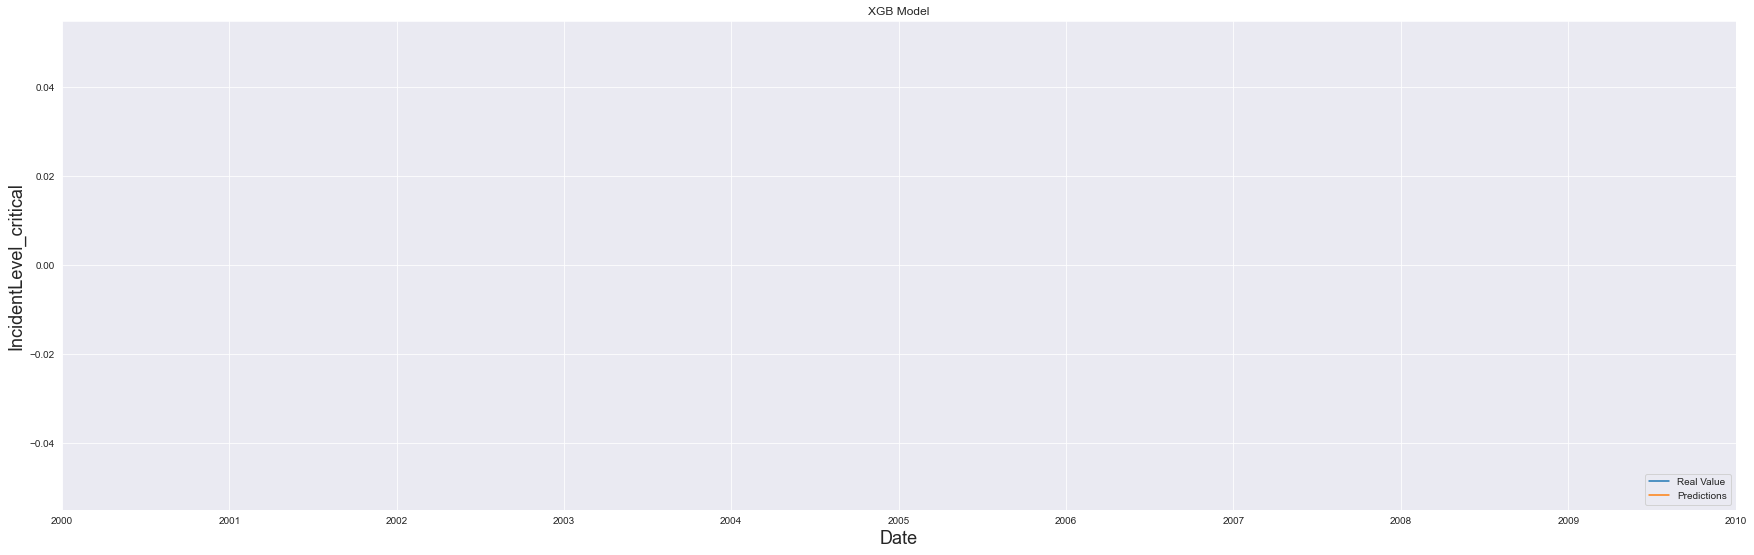

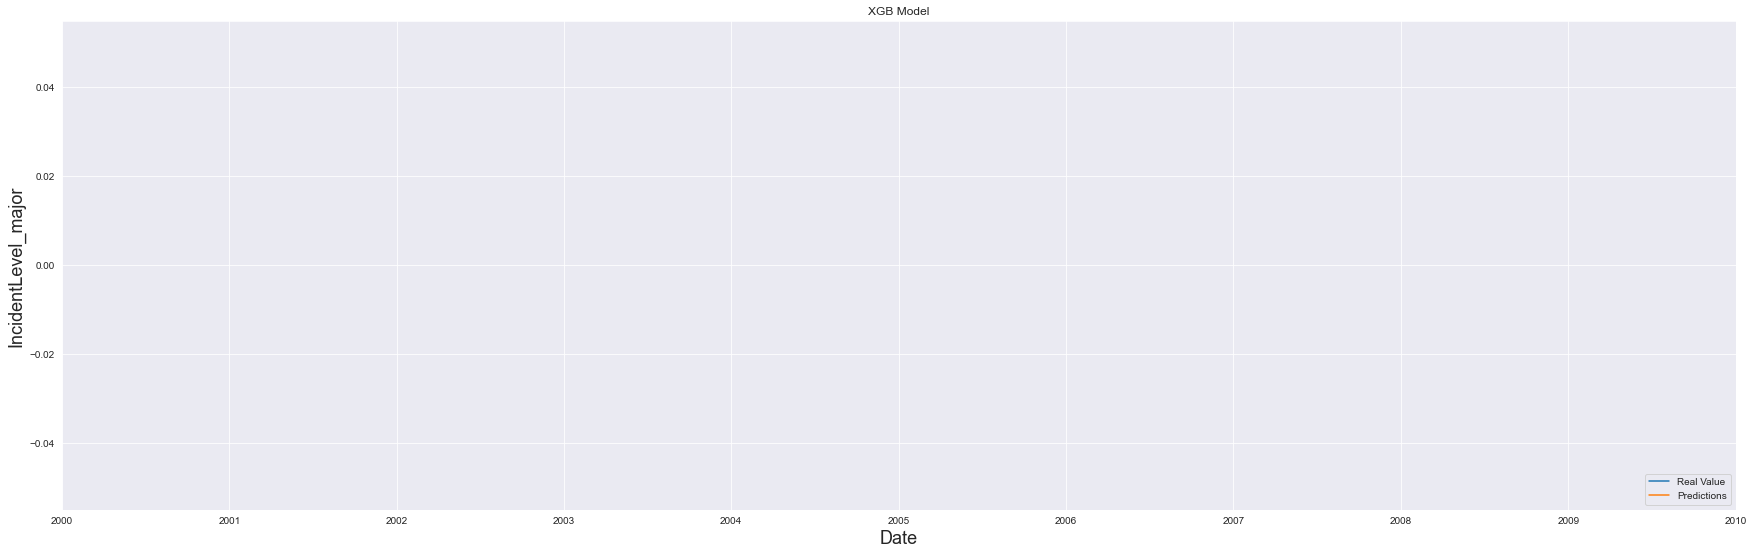

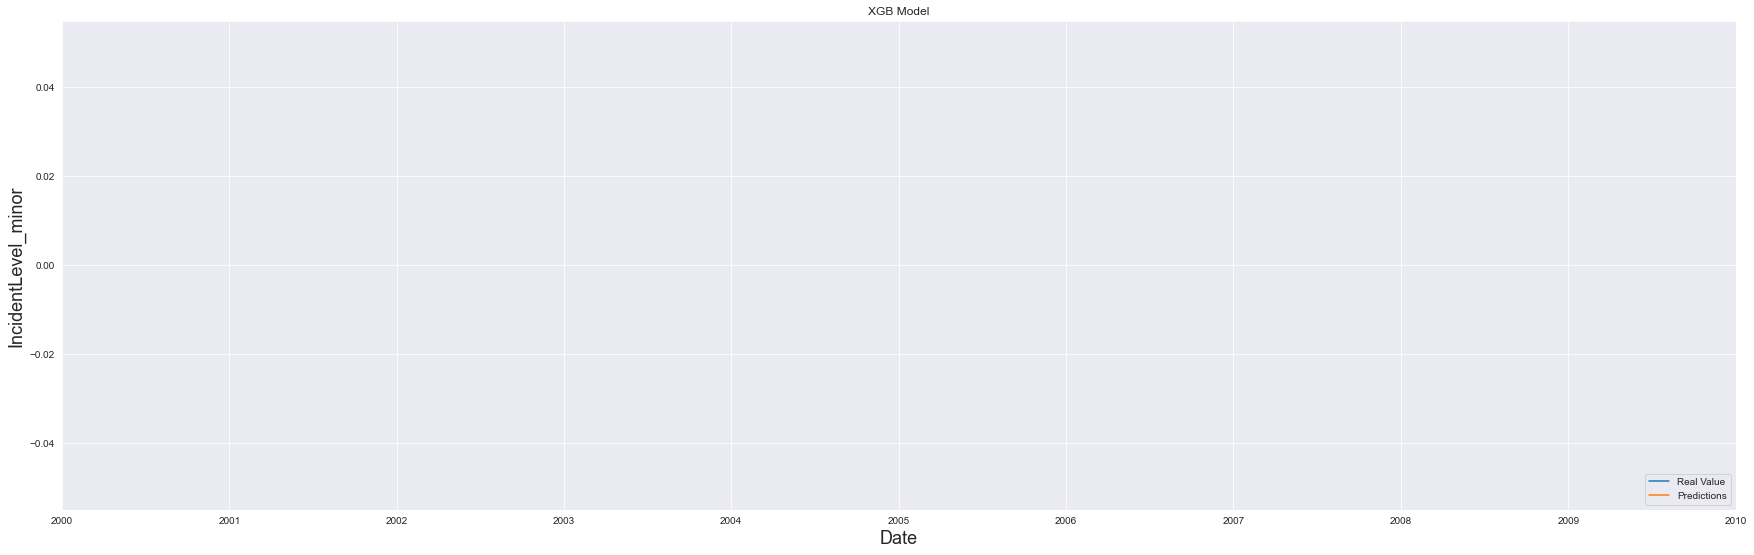

In [ ]:
def vis(col1,col2):
# Visualize the data
    valid = res.set_index('Date')[[col1,col2]]
    
    plt.figure(figsize=(30,9))
    plt.title('XGB Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(col1, fontsize=18)
    plt.plot(valid)
    plt.legend([ 'Real Value', 'Predictions'], loc='lower right')
    plt.show()

vis('IncidentLevel_critical','Predicted IncidentLevel_critical')
vis('IncidentLevel_major','Predicted IncidentLevel_major')
vis('IncidentLevel_minor','Predicted IncidentLevel_minor')

### From the last graphs we can see that the IncidentLevel_critical predictions were very poor, but on the other hand we can find that both IncidentLevel_major and IncidentLevel_minor are good enough to be counted on.